In [ ]:
%reset

In [1]:
import pandas as pd
import numpy as np

In [88]:
##Cost calculation
def cost(scaler,dmnd,mlp,cost_shortage, cost_outdate):

    
    Demand=[dmnd['Demand1'].values.tolist(),dmnd['Demand2'].values.tolist(),dmnd['Demand3'].values.tolist(),
        dmnd['Demand4'].values.tolist()]
    #print(Demand[0][0:5])
    period=9250
    T=7  #period
    D= 100  # number of  scenarios
    #b=[[0, 3, 2, 3, 0, 0, 3, 4, 3, 3, 3],[0, 0, 2, 0, 3, 2, 3, 2, 1, 2, 1],[4, 5, 5, 9, 10, 8, 6, 9, 10, 7, 7],
       #[6, 9, 3, 7, 2, 6, 5, 5, 4, 5, 4]] ##Initial inventory
    
    b=[[1, 0, 2, 2, 1, 0, 2, 3, 4, 4, 4],[0, 0, 1, 1, 2, 3, 4, 1, 1, 0, 3],[3, 4, 6, 8, 9, 8, 6, 8, 9, 8, 6],
       [5, 8, 4, 6, 2, 5, 5, 6, 3, 4, 5]]
    M = 11 ##len (b[0]) #life time period
    N = 4 ##len (b) #number of hospital 

    #n=[4,3,15,15]
    #p=[0.6,0.57,0.57,0.48]
    RD=[[0 for k in range(period)] for j in range(N)] #relized demand
    #RD = read_dat_file("ZINB.txt")
    RD=Demand
    #print(RD[1][0:5])
    G = [cost_shortage for j in range(N)]  #The emergency order cost at each hospital
    H = [1 for j in range(N)]  #The holding cost at each hospital
    H1=[[1 for j in range (M)]for i in range (N)]

    E = [cost_outdate for j in range(N)]  #The expiry cost at each hospital
    R = [1 for j in range(N)]  #The order cost at each hospital
    C =[[1.5 for j in range(N)] for i in range(N)] # transshipment cost.the first dimention shows the origin hospital and 
#the second one shows the destination hospital
    CTS=[0 for i in range (period)]
    shortage=[0 for i in range (period)]
    Orders=[0 for i in range (period)]
    ## consideing these two additional costs
    HoldCost= [0 for i in range (period)]
    CoutCost=[0 for i in range (period)]
    TransCost=[0 for i in range (period)]
    
    CTSTotal=0
    fiorder = open('NewDemandorder.txt', 'w')
    fitrans = open('NewDemandtrans.txt', 'w')
    fiout = open('NewDemandoutdate.txt', 'w')
    fishortage = open('NewDemandshortage.txt', 'w')
    fiissue = open('NewDemandissue.txt', 'w')
    fiinventory = open('inventoryNewDemand.txt', 'w')
    fitranscost = open('transcost.txt', 'w')
#fioutcost = open('currentoutdatecost.txt', 'w')
#fishortagecost = open('currentshortagecost.txt', 'w')
    fiholdcost = open('holdcost.txt', 'w')
    
    for t in range (period):
        
        fiinventory.write(("\n["))
        for item in b:
            fiinventory.write("%s," % item) 
        fiinventory.write("]")                   
        
        Y = [0 for i in range(N)]   #orders
        X= [[[0 for k in range(M)] for j in range(N)] for i in range(N)]  #X[hi][hf][age] : transshipment matrix
        X1= [0 for j in range(N)] 
        
        #bnew=np.array(b).reshape(1,44).reshape(1,-1)
        btransform=scaler.transform(np.array(b).reshape(1,44).reshape(1,-1))   ##**input scaler for MLP model** 
        prediction = mlp.predict(btransform.reshape(1,44))
      
        #prediction = mlp.predict(np.array(b).reshape(1,44).reshape(1,-1))


        prediction[prediction<0]=0

        prediction=np.round(prediction,0)

        d=prediction[0][0:176]       #Transshipments
        X=d.reshape(4,4,11)

        Y=prediction[0][176:180]     #'order1':'order4'
        
    
    #Y,X = twosatge(b,N,M,T,D,G,H1,E,R,C)
    
        Corder=0
        Ctrans=0
        Cshort=0
        Chold=0
        Cout=0
        #CTS=0
        issue=[[0 for j in range (M)]for i in range (N)]
        bD=[[0 for j in range (M)]for i in range (N)] #inventory after satisfying demand
        by=[[0 for j in range (M)]for i in range (N)] #inventory after reciving order 
        F =[0 for i in range (N)]  # shortage at each hospital
        Hunit =[0 for i in range (N)]  # total units which stay in system for one period at each hospital
        Ounit=[0 for i in range (N)]  # outdate at each hospital
        XIN= [[0 for j in range (M)]for i in range (N)]
        XOUT= [[0 for j in range (M)]for i in range (N)] 
        bx= [[0 for j in range (M)]for i in range (N)] #inventory after transshipment
        for i in range (N):
            for j in range (M):
                k=0
                for l in range (N):
                    k=k+X[i][l][j]
                XOUT[i][j]=k
        for i in range (N):
            for j in range (M):
                k=0
                for l in range (N):
                    k=k+X[l][i][j]
                XIN[i][j]=k
        for i in range (N):
            q=0
            for j in range (N):
                for k in range (M):
                    q= q+X[i][j][k]
            X1[i]=q		
        for i in range (N):
            for j in range (M):
                bx[i][j]= b[i][j]+XIN[i][j]-XOUT[i][j]
        for i in range (N):
            for j in range (M):
                if bx[i][j]>RD[i][t]:
                    bD[i][j]= bx[i][j]-RD[i][t]
                    issue[i][j]=RD[i][t]
                    RD[i][t]=0
                else:
                    issue[i][j]=bx[i][j]
                    bD[i][j]=0
                    RD[i][t]=RD[i][t]-bx[i][j]
            if RD[i][t]>0:
                F[i]=RD[i][t]	
        for i in range (N):
            Ounit[i]= bD[i][0] 
        for i in range (N):
            j=1
            k=0
            while j<M:
                k= k+bD[i][j]
                j=j+1
            Hunit[i]=k
        for i in range (N):
            for j in range (M):
                if j==(M-1):
                    by[i][j]=Y[i] 
                else:
                    by[i][j]= bD[i][j+1]
        for i in range (N):
            for j in range (M):	
                b[i][j]=by[i][j]				
        for i in range (N):
            Corder= Corder +R[i]*Y[i]
        for i in range (N):
                for j in range (N):
                    for l in range (M):
                        Ctrans = Ctrans+C[i][j]*X[i][j][l]
        for i in range (N):
            Cshort=Cshort+F[i]*G[i]
            Chold=Chold+Hunit[i]*H[i]
            Cout=Cout+Ounit[i]*E[i]
        CTS[t]=Corder+Ctrans+Cshort+Chold+Cout
        shortage[t]=Cshort
        Orders[t]=Corder
        # adding the trans and hoding cost and count
        TransCost[t]=Ctrans
        HoldCost[t]=Chold
        CoutCost[t]=Cout
        ## continue with others
        CTSTotal = CTSTotal+CTS[t]
        fiholdcost.write(("\n\n["))
        for item in Hunit:
            fiholdcost.write("%s," % item) 
        fiholdcost.write("]")
        fitranscost.write(("\n\n["))
        for item in X1:
            fitranscost.write("%s," % item) 
        fitranscost.write("]")
        fiorder.write(("\n\n["))
        for item in Y:
            fiorder.write("%s," % item) 
        fiorder.write("]")
        fiout.write(("\n\n["))
        for item in Ounit:
            fiout.write("%s," % item)
        fiout.write("]")
        fishortage.write(("\n\n["))
        for item in F:
            fishortage.write("%s," % item)
        fishortage.write("]")
        fitrans.write(("\n["))
        for item in d:
            fitrans.write("%s," % item)
        fiissue.write(("\n\n["))
        for item in issue:
            fiissue.write("%s," % item)
        fiissue.write("]")	
    fo = open('cost.txt', 'w')
    fo.write("\n\n[")
    for item in CTS:
        fo.write("%s," % item)
    fo.write("]")
    fo.write("\n\nCTSTotal=")
    fo.write("%s" %CTSTotal) 
    fo.close() 
    fiorder.close()
    fiout.close()
    fitrans.close()
    fishortage.close()   
    fiissue.close()	
    fiinventory.close()
    fiholdcost.close()	
    fitranscost.close()       
	

#print (RD)
#print (CTS)
    #print ('Average Cost:',np.mean(CTS))
    #print ('std of Cost:',np.std(CTS))
    #print('NO. of days:',len(df))
    
    return(shortage,Orders,CTS,HoldCost,TransCost,CoutCost)

In [89]:
##Cost calculation for Keras models
def costK(scaler,dmnd,mlp,cost_shortage, cost_outdate):

    
    Demand=[dmnd['Demand1'].values.tolist(),dmnd['Demand2'].values.tolist(),dmnd['Demand3'].values.tolist(),
        dmnd['Demand4'].values.tolist()]
    #print(Demand[0][0:5])
    period=9250
    T=7  #period
    D= 100  # number of  scenarios
    #b=[[0, 3, 2, 3, 0, 0, 3, 4, 3, 3, 3],[0, 0, 2, 0, 3, 2, 3, 2, 1, 2, 1],[4, 5, 5, 9, 10, 8, 6, 9, 10, 7, 7],
       #[6, 9, 3, 7, 2, 6, 5, 5, 4, 5, 4]] ##Initial inventory
    
    b=[[1, 0, 2, 2, 1, 0, 2, 3, 4, 4, 4],[0, 0, 1, 1, 2, 3, 4, 1, 1, 0, 3],[3, 4, 6, 8, 9, 8, 6, 8, 9, 8, 6],
       [5, 8, 4, 6, 2, 5, 5, 6, 3, 4, 5]]
    M = 11 ##len (b[0]) #life time period
    N = 4 ##len (b) #number of hospital 

    #n=[4,3,15,15]
    #p=[0.6,0.57,0.57,0.48]
    RD=[[0 for k in range(period)] for j in range(N)] #relized demand
    #RD = read_dat_file("ZINB.txt")
    RD=Demand
    #print(RD[1][0:5])
    G = [cost_shortage for j in range(N)]  #The emergency order cost at each hospital
    H = [1 for j in range(N)]  #The holding cost at each hospital
    H1=[[1 for j in range (M)]for i in range (N)]

    E = [cost_outdate for j in range(N)]  #The expiry cost at each hospital
    R = [1 for j in range(N)]  #The order cost at each hospital
    C =[[1.5 for j in range(N)] for i in range(N)] # transshipment cost.the first dimention shows the origin hospital and 
#the second one shows the destination hospital
    CTS=[0 for i in range (period)]
    shortage=[0 for i in range (period)]
    Orders=[0 for i in range (period)]
    ## consideing these two additional costs
    HoldCost= [0 for i in range (period)]
    CoutCost=[0 for i in range (period)]
    TransCost=[0 for i in range (period)]
    
    CTSTotal=0
    fiorder = open('DTNewDemandorder.txt', 'w')
    fitrans = open('DTNewDemandtrans.txt', 'w')
    fiout = open('DTNewDemandoutdate.txt', 'w')
    fishortage = open('DTNewDemandshortage.txt', 'w')
    fiissue = open('DTNewDemandissue.txt', 'w')
    fiinventory = open('DTinventoryNewDemand.txt', 'w')
    fitranscost = open('DTtranscost.txt', 'w')
#fioutcost = open('currentoutdatecost.txt', 'w')
#fishortagecost = open('currentshortagecost.txt', 'w')
    fiholdcost = open('DTholdcost.txt', 'w')
    
    for t in range (period):
        
        fiinventory.write(("\n["))
        for item in b:
            fiinventory.write("%s," % item) 
        fiinventory.write("]")                   
        
        Y = [0 for i in range(N)]   #orders
        X= [[[0 for k in range(M)] for j in range(N)] for i in range(N)]  #X[hi][hf][age] : transshipment matrix
        X1= [0 for j in range(N)] 
        
        #b=np.array(b).reshape(1,44).reshape(1,-1)
        #btransform=scaler.transform(np.array(b).reshape(1,44).reshape(1,-1))   ##**input scaler for MLP model** 
        prediction = [mlpk[t]]
      
        #prediction = mlp.predict(np.array(b).reshape(1,44).reshape(1,-1))
        
        #lgbTestData = lightgbm.Dataset(np.array(b).reshape(1,44).reshape(1,-1))
        
        #prediction = mdl.predict(lgbTestData)

        #prediction[prediction<0]=0

        prediction=np.round(prediction,0)

        d=prediction[0][0:176]       #Transshipments
        X=d.reshape(4,4,11)

        Y=prediction[0][176:180]     #'order1':'order4'
        
    
    #Y,X = twosatge(b,N,M,T,D,G,H1,E,R,C)
    
        Corder=0
        Ctrans=0
        Cshort=0
        Chold=0
        Cout=0
        #CTS=0
        issue=[[0 for j in range (M)]for i in range (N)]
        bD=[[0 for j in range (M)]for i in range (N)] #inventory after satisfying demand
        by=[[0 for j in range (M)]for i in range (N)] #inventory after reciving order 
        F =[0 for i in range (N)]  # shortage at each hospital
        Hunit =[0 for i in range (N)]  # total units which stay in system for one period at each hospital
        Ounit=[0 for i in range (N)]  # outdate at each hospital
        XIN= [[0 for j in range (M)]for i in range (N)]
        XOUT= [[0 for j in range (M)]for i in range (N)] 
        bx= [[0 for j in range (M)]for i in range (N)] #inventory after transshipment
        for i in range (N):
            for j in range (M):
                k=0
                for l in range (N):
                    k=k+X[i][l][j]
                XOUT[i][j]=k
        for i in range (N):
            for j in range (M):
                k=0
                for l in range (N):
                    k=k+X[l][i][j]
                XIN[i][j]=k
        for i in range (N):
            q=0
            for j in range (N):
                for k in range (M):
                    q= q+X[i][j][k]
            X1[i]=q		
        for i in range (N):
            for j in range (M):
                bx[i][j]= b[i][j]+XIN[i][j]-XOUT[i][j]
        for i in range (N):
            for j in range (M):
                if bx[i][j]>RD[i][t]:
                    bD[i][j]= bx[i][j]-RD[i][t]
                    issue[i][j]=RD[i][t]
                    RD[i][t]=0
                else:
                    issue[i][j]=bx[i][j]
                    bD[i][j]=0
                    RD[i][t]=RD[i][t]-bx[i][j]
            if RD[i][t]>0:
                F[i]=RD[i][t]	
        for i in range (N):
            Ounit[i]= bD[i][0] 
        for i in range (N):
            j=1
            k=0
            while j<M:
                k= k+bD[i][j]
                j=j+1
            Hunit[i]=k
        for i in range (N):
            for j in range (M):
                if j==(M-1):
                    by[i][j]=Y[i] 
                else:
                    by[i][j]= bD[i][j+1]
        for i in range (N):
            for j in range (M):	
                b[i][j]=by[i][j]				
        for i in range (N):
            Corder= Corder +R[i]*Y[i]
        for i in range (N):
                for j in range (N):
                    for l in range (M):
                        Ctrans = Ctrans+C[i][j]*X[i][j][l]
        for i in range (N):
            Cshort=Cshort+F[i]*G[i]
            Chold=Chold+Hunit[i]*H[i]
            Cout=Cout+Ounit[i]*E[i]
        CTS[t]=Corder+Ctrans+Cshort+Chold+Cout
        shortage[t]=Cshort
        Orders[t]=Corder
        # adding the trans and hoding cost and count
        TransCost[t]=Ctrans
        HoldCost[t]=Chold
        CoutCost[t]=Cout
        ## continue with others
        CTSTotal = CTSTotal+CTS[t]
        fiholdcost.write(("\n\n["))
        for item in Hunit:
            fiholdcost.write("%s," % item) 
        fiholdcost.write("]")
        fitranscost.write(("\n\n["))
        for item in X1:
            fitranscost.write("%s," % item) 
        fitranscost.write("]")
        fiorder.write(("\n\n["))
        for item in Y:
            fiorder.write("%s," % item) 
        fiorder.write("]")
        fiout.write(("\n\n["))
        for item in Ounit:
            fiout.write("%s," % item)
        fiout.write("]")
        fishortage.write(("\n\n["))
        for item in F:
            fishortage.write("%s," % item)
        fishortage.write("]")
        fitrans.write(("\n["))
        for item in d:
            fitrans.write("%s," % item)
        fiissue.write(("\n\n["))
        for item in issue:
            fiissue.write("%s," % item)
        fiissue.write("]")	
    fo = open('DTcost.txt', 'w')
    fo.write("\n\n[")
    for item in CTS:
        fo.write("%s," % item)
    fo.write("]")
    fo.write("\n\nCTSTotal=")
    fo.write("%s" %CTSTotal) 
    fo.close() 
    fiorder.close()
    fiout.close()
    fitrans.close()
    fishortage.close()   
    fiissue.close()	
    fiinventory.close()
    fiholdcost.close()	
    fitranscost.close()       
	

#print (RD)
#print (CTS)
    #print ('Average Cost:',np.mean(CTS))
    #print ('std of Cost:',np.std(CTS))
    #print('NO. of days:',len(df))
    
    return(shortage,Orders,CTS,HoldCost,TransCost,CoutCost)

In [324]:
b=np.array([[1, 0, 2, 2, 1, 0, 2, 3, 4, 4, 4],[0, 0, 1, 1, 2, 3, 4, 1, 1, 0, 3],[3, 4, 6, 8, 9, 8, 6, 8, 9, 8, 6],
       [5, 8, 4, 6, 2, 5, 5, 6, 3, 4, 5]])
#scaler.transform(b)
m= np.append(b,[[1,2,3,4,5,6,5,8,0,1,1]]).reshape(1,55)
m
StandardScaler().fit_transform(m)
#m2=np.array(m.reshape(1,55))
#m2
#scaler.transform(m)
#b

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]])

In [325]:
##Cost calculation
period=9250
def costn(scaler,dmnd,ml,cost_shortage, cost_outdate):

    
    Demand=[dmnd['Demand1'].values.tolist(),dmnd['Demand2'].values.tolist(),dmnd['Demand3'].values.tolist(),
        dmnd['Demand4'].values.tolist()]
    #print(Demand[0][0:5])
    period=9250
    T=7  #period
    D= 100  # number of  scenarios
    #b=[[0, 3, 2, 3, 0, 0, 3, 4, 3, 3, 3],[0, 0, 2, 0, 3, 2, 3, 2, 1, 2, 1],[4, 5, 5, 9, 10, 8, 6, 9, 10, 7, 7],
       #[6, 9, 3, 7, 2, 6, 5, 5, 4, 5, 4]] ##Initial inventory
    b=[[1, 0, 2, 2, 1, 0, 2, 3, 4, 4, 4],[0, 0, 1, 1, 2, 3, 4, 1, 1, 0, 3],[3, 4, 6, 8, 9, 8, 6, 8, 9, 8, 6],
       [5, 8, 4, 6, 2, 5, 5, 6, 3, 4, 5]]
  
  #  b=[[1, 0, 2, 2, 1, 0, 2, 3, 4, 4, 4,0],[0, 1, 1, 2, 3, 4, 1, 1, 0, 3,3,4],[ 6, 8, 9, 8, 6, 8, 9, 8, 6,
   #    5,8, 4],[ 6, 2, 5, 5, 6, 3, 4, 5,2,0,0,0]]
    
    M = 11 ##len (b[0]) #life time period
    N = 4 ##len (b) #number of hospital 

    #n=[4,3,15,15]
    #p=[0.6,0.57,0.57,0.48]
    RD=[[0 for k in range(period)] for j in range(N)] #relized demand
    #RD = read_dat_file("ZINB.txt")
    RD=Demand
    #print(RD[1][0:5])
    G = [cost_shortage for j in range(N)]  #The emergency order cost at each hospital
    H = [1 for j in range(N)]  #The holding cost at each hospital
    H1=[[1 for j in range (M)]for i in range (N)]

    E = [cost_outdate for j in range(N)]  #The expiry cost at each hospital
    R = [1 for j in range(N)]  #The order cost at each hospital
    C =[[1.5 for j in range(N)] for i in range(N)] # transshipment cost.the first dimention shows the origin hospital and 
    #the second one shows the destination hospital
    CTS=[0 for i in range (period)]
    shortage=[0 for i in range (period)]
    Orders=[0 for i in range (period)]
    ## consideing these two additional costs
    HoldCost= [0 for i in range (period)]
    CoutCost=[0 for i in range (period)]
    TransCost=[0 for i in range (period)]
    
    CTSTotal=0
    fiorder = open('nNewDemandorder.txt', 'w')
    fitrans = open('nNewDemandtrans.txt', 'w')
    fiout = open('nNewDemandoutdate.txt', 'w')
    fishortage = open('nNewDemandshortage.txt', 'w')
    fiissue = open('nNewDemandissue.txt', 'w')
    fiinventory = open('ninventoryNewDemand.txt', 'w')
    fitranscost = open('ntranscost.txt', 'w')
    #fioutcost = open('currentoutdatecost.txt', 'w')
    #fishortagecost = open('currentshortagecost.txt', 'w')
    fiholdcost = open('nholdcost.txt', 'w')
    fiinventoryTS = open('ninventoryTS.txt', 'w')

    Corder=0
    Ctrans=0
    Cshort=0
    Chold=0
    Cout=0
    
    for t in range (period):
        
        fiinventory.write(("\n["))
        for item in b:
            fiinventory.write("%s," % item) 
        fiinventory.write("]")                   
        
        Y = [0 for i in range(N)]   #orders
        X= [[[0 for k in range(M)] for j in range(N)] for i in range(N)]  #X[hi][hf][age] : transshipment matrix
        X1= [0 for j in range(N)] 
        

        
        #b_new=np.concatenate(np.array(b).reshape(1,44), np.array(HoldCost[0][t]),np.array(TransCost[0][t]))
        #prediction = ml.predict(np.array(b_new).reshape(1,48).reshape(1,-1))
        #prediction = [ml.predict(X_test_n)[t]]
        #prediction = ml.predict(X_test_n[t,:].reshape(1, -1))
        #prediction = ml.predict(X_all_n[t,:].reshape(1, -1))
        
        Corder=0
        Ctrans=0
        Cshort=0
        Chold=0
        Cout=0
      
        
        #b_new=np.concatenate(b,[Corder,Ctrans,Corder,Ctrans,Corder,Ctrans,Corder,Ctrans,Corder,Ctrans,Corder]).reshape(1,55)
        #b_new=np.append(b,[[TransCost[t],TransCost[t],TransCost[t],TransCost[t],TransCost[t],HoldCost[t],HoldCost[t],HoldCost[t],HoldCost[t],HoldCost[t],HoldCost[t]]], axis=0)

        b_new=np.append(b,[[TransCost[t],TransCost[t], Orders[t],Orders[t], CoutCost[t],CoutCost[t], shortage[t],shortage[t], HoldCost[t],HoldCost[t], CTS[t]]], axis=0).reshape(1,55).reshape(1,-1)
        #b_new=np.append(b,[[TransCost[t],TransCost[t]]], axis=0).reshape(1,46)

        b_new_transform=StandardScaler().fit_transform(b_new)
        prediction = ml.predict(b_new.reshape(1,55))
 

        #Use the one below only for MLP
        #prediction = ml.predict(scaler.transform(np.array(b_new).reshape(1,55).reshape(1,-1)))
        prediction=np.round(prediction,0)
        prediction[prediction<0]=0
        
        d=prediction[0][0:176]       #Transshipments
        X=d.reshape(4,4,11)

        Y=prediction[0][176:180]     #'order1':'order4'
        
        #CTS=0
        issue=[[0 for j in range (M)]for i in range (N)]
        bD=[[0 for j in range (M)]for i in range (N)] #inventory after satisfying demand
        by=[[0 for j in range (M)]for i in range (N)] #inventory after reciving order 
        F =[0 for i in range (N)]  # shortage at each hospital
        Hunit =[0 for i in range (N)]  # total units which stay in system for one period at each hospital
        Ounit=[0 for i in range (N)]  # outdate at each hospital
        XIN= [[0 for j in range (M)]for i in range (N)]
        XOUT= [[0 for j in range (M)]for i in range (N)] 
        bx= [[0 for j in range (M)]for i in range (N)] #inventory after transshipment
        for i in range (N):
            for j in range (M):
                k=0
                for l in range (N):
                    k=k+X[i][l][j]
                XOUT[i][j]=k
        for i in range (N):
            for j in range (M):
                k=0
                for l in range (N):
                    k=k+X[l][i][j]
                XIN[i][j]=k
        for i in range (N):
            q=0
            for j in range (N):
                for k in range (M):
                    q= q+X[i][j][k]
            X1[i]=q		
        for i in range (N):
            for j in range (M):
                bx[i][j]= b[i][j]+XIN[i][j]-XOUT[i][j]
        for i in range (N):
            for j in range (M):
                if bx[i][j]>RD[i][t]:
                    bD[i][j]= bx[i][j]-RD[i][t]
                    issue[i][j]=RD[i][t]
                    RD[i][t]=0
                else:
                    issue[i][j]=bx[i][j]
                    bD[i][j]=0
                    RD[i][t]=RD[i][t]-bx[i][j]
            if RD[i][t]>0:
                F[i]=RD[i][t]	
        for i in range (N):
            Ounit[i]= bD[i][0] 
        for i in range (N):
            j=1
            k=0
            while j<M:
                k= k+bD[i][j]
                j=j+1
            Hunit[i]=k
        for i in range (N):
            for j in range (M):
                if j==(M-1):
                    by[i][j]=Y[i] 
                else:
                    by[i][j]= bD[i][j+1]
        for i in range (N):
            for j in range (M):	
                b[i][j]=by[i][j]				
        for i in range (N):
            Corder= Corder +R[i]*Y[i]
        for i in range (N):
                for j in range (N):
                    for l in range (M):
                        Ctrans = Ctrans+C[i][j]*X[i][j][l]
        for i in range (N):
            Cshort=Cshort+F[i]*G[i]
            Chold=Chold+Hunit[i]*H[i]
            Cout=Cout+Ounit[i]*E[i]
        CTS[t]=Corder+Ctrans+Cshort+Chold+Cout
        shortage[t]=Cshort
        Orders[t]=Corder
        # adding the trans and hoding cost and count
        TransCost[t]=Ctrans
        HoldCost[t]=Chold
        CoutCost[t]=Cout
        ## continue with others
        CTSTotal = CTSTotal+CTS[t]
        fiholdcost.write(("\n\n["))

        for item in Hunit:
            fiholdcost.write("%s," % item) 
        fiholdcost.write("]")
        fitranscost.write(("\n\n["))
        for item in X1:
            fitranscost.write("%s," % item) 
        fitranscost.write("]")
        fiorder.write(("\n\n["))
        for item in Y:
            fiorder.write("%s," % item) 
        fiorder.write("]")
        fiout.write(("\n\n["))
        for item in Ounit:
            fiout.write("%s," % item)
        fiout.write("]")
        fishortage.write(("\n\n["))
        for item in F:
            fishortage.write("%s," % item)
        fishortage.write("]")
        fitrans.write(("\n["))
        for item in d:
            fitrans.write("%s," % item)
        fiissue.write(("\n\n["))
        for item in issue:
            fiissue.write("%s," % item)
        fiissue.write("]")	
        
        fiinventoryTS.write(("\n["))
        for item in bx:                   # b: inventory after transshipment 
            fiinventoryTS.write("%s," % item) 
        fiinventoryTS.write("]") 
        
    fo = open('ncost.txt', 'w')
    fo.write("\n\n[")
    for item in CTS:
        fo.write("%s," % item)
    fo.write("]")
    fo.write("\n\nCTSTotal=")
    fo.write("%s" %CTSTotal) 
    
    fo.close() 
    fiorder.close()
    fiout.close()
    fitrans.close()
    fishortage.close()   
    fiissue.close()	
    fiinventory.close()
    fiinventoryTS.close()
    fiholdcost.close()	
    fitranscost.close()       
	

#print (RD)
#print (CTS)
    #print ('Average Cost:',np.mean(CTS))
    #print ('std of Cost:',np.std(CTS))
    #print('NO. of days:',len(df))
    
    return( shortage,Orders,CTS,HoldCost,TransCost,CoutCost)

In [6]:
%cd '/Users/mahdi/Documents/Postdoc/RMIT /Code/new/50/fwdcodesMLP'
    
df = pd.read_csv('/Users/mahdi/Documents/Postdoc/RMIT /Code/new/50/fwdcodesMLP/Final14.csv')
# Getting dataframe columns names
df_name=df.columns

days=np.arange(len(df))+1

data = np.load('final14.npy')
Xin=data[0:period,0:44]
yin=data[0:period,44:224] #only outputs


/Users/mahdi/Documents/Postdoc/RMIT /Code/new/50/fwdcodesMLP


In [7]:
period

9250

In [8]:
dfDemand = pd.read_excel('/Users/mahdi/Documents/Postdoc/RMIT /Code/new/50/fwdcodesMLP/demand2.xlsx')

dmnd=dfDemand
Demand=[dmnd['Demand1'].values.tolist(),dmnd['Demand2'].values.tolist(),dmnd['Demand3'].values.tolist(),
    dmnd['Demand4'].values.tolist()]

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xin, yin, test_size=0.10, random_state=45)

In [158]:
%cd '/Users/mahdi/Documents/Postdoc/RMIT /Code/new/50/fwdcodesMLP'

X_train_n = np.load('X_train_n.npy', allow_pickle=True)

/Users/mahdi/Documents/Postdoc/RMIT /Code/new/50/fwdcodesMLP


In [159]:
Xin.shape

(9250, 44)

In [196]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xtransform=scaler.fit_transform(Xin)  # normalizing inputs

array([[-0.15753819, -0.26634724, -0.33008378, ...,  2.07075279,
         2.07075279, -1.72495405],
       [-0.15753819, -0.26634724,  4.58662304, ...,  1.18693451,
         1.18693451, -1.72470826],
       [-0.15753819, -0.26634724, -0.33008378, ...,  0.8334072 ,
         0.8334072 , -1.72444281],
       ...,
       [-0.15753819, -0.26634724, -0.33008378, ..., -0.93422936,
        -0.93422936,  1.71838256],
       [-0.15753819, -0.26634724, -0.33008378, ..., -0.58070205,
        -0.58070205,  1.71882936],
       [-0.15753819, -0.26634724,  2.94772077, ..., -0.93422936,
        -0.93422936,  1.71925758]])

In [24]:
from sklearn.multioutput import MultiOutputRegressor

In [56]:
mlp = MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(7,7), activation= 'tanh', momentum= 0.7, solver= 'adam')).fit(Xtransform, yin)

In [26]:
shortage_mlp1,Orders_mlp1,CTS_mlp1, Inventory_mlp1, Trans_mlp1, Out_mlp1 =cost(scaler,dmnd,mlp,cost_shortage=14, cost_outdate=11)

In [27]:
np.mean(CTS_mlp1) ,np.mean(shortage_mlp1),np.mean(Orders_mlp1), np.mean(Inventory_mlp1), np.mean(Trans_mlp1), np.mean(Out_mlp1) 

(76.78518918918918,
 5.339675675675676,
 22.425405405405407,
 45.391351351351354,
 1.7652972972972973,
 1.8634594594594596)

In [60]:
Xtransform_n=scaler.fit_transform(X_train_n[0:9250,:])  # normalizing inputs 

In [61]:
mlpn = MLPRegressor(hidden_layer_sizes=(7,7), activation= 'tanh', momentum= 0.7, solver= 'adam')
mlpn = mlpn.fit(Xtransform_n,yin[0:9250,])

/Users/mahdi/opt/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [62]:
shortage_mlpn,Orders_mlpn,CTS_mlpn, Inventory_mlpn, Trans_mlpn, Out_mlpn =costn(scaler,dmnd,mlpn,cost_shortage=14, cost_outdate=11)

In [63]:
np.mean(CTS_mlpn) ,np.mean(shortage_mlpn),np.mean(Orders_mlpn), np.mean(Inventory_mlpn), np.mean(Trans_mlpn), np.mean(Out_mlpn) 

(121.05691891891892,
 63.39048648648649,
 18.33308108108108,
 36.88518918918919,
 0.0008108108108108108,
 2.4473513513513514)

In [27]:
#pip install hep_ml

In [85]:
import hep_ml as hml

In [86]:
from hep_ml.nnet import MLPRegressor

In [118]:
#network1 = MLPRegressor(layers=[7,7], loss='mae_loss', trainer='irprop-', epochs=100)
network2 = MLPRegressor(layers=[7,7], loss='mse_loss', trainer='irprop-', epochs=100)
network3 = MLPRegressor(layers=[7,7], loss='smooth_huber_loss', trainer='irprop-', epochs=50)
#network1.fit(X_train, yin[0:1665,1])
#probability = network1.predict(X_test)

In [92]:
#git clone https://github.com/arogozhnikov/hep_ml.git
#cd hep_ml
#pip install .

In [19]:
#mlp1 = MultiOutputRegressor(network1).fit(Xtransform, yin)

In [208]:
shortage_mlp1,Orders_mlp1,CTS_mlp1, Inventory_mlp1, Trans_mlp1, Out_mlp1 =cost(scaler,dmnd,mlp1,cost_shortage=14, cost_outdate=11)

In [209]:
np.mean(CTS_mlp1) ,np.mean(shortage_mlp1),np.mean(Orders_mlp1), np.mean(Inventory_mlp1), np.mean(Trans_mlp1), np.mean(Out_mlp1) 

(77.19243243243243,
 5.6454054054054055,
 22.173513513513512,
 45.71081081081081,
 1.4805405405405405,
 2.1821621621621623)

In [91]:
mlp2 = MultiOutputRegressor(network2).fit(Xtransform, yin)

In [93]:
shortage_mlp2,Orders_mlp2,CTS_mlp2, Inventory_mlp2, Trans_mlp2, Out_mlp2 = cost(scaler,dmnd,mlp2,cost_shortage=14, cost_outdate=11)

In [94]:
np.mean(CTS_mlp2) ,np.mean(shortage_mlp2),np.mean(Orders_mlp2), np.mean(Inventory_mlp2), np.mean(Trans_mlp2), np.mean(Out_mlp2) 

(77.3108108108108,
 6.74572972972973,
 22.33545945945946,
 44.83448648648648,
 1.4127567567567567,
 1.9823783783783784)

In [209]:
np.mean(CTS_mlp2) ,np.mean(shortage_mlp2),np.mean(Orders_mlp2), np.mean(Inventory_mlp2), np.mean(Trans_mlp2), np.mean(Out_mlp2) 

(77.19243243243243,
 5.6454054054054055,
 22.173513513513512,
 45.71081081081081,
 1.4805405405405405,
 2.1821621621621623)

In [329]:
mlp2n = MultiOutputRegressor(network2).fit(Xtransform_n, yin)

In [330]:
shortage_mlp2n,Orders_mlp2n,CTS_mlp2n, Inventory_mlp2n, Trans_mlp2n, Out_mlp2n = costn(scaler,dmnd,mlp2n,cost_shortage=14, cost_outdate=11)

In [331]:
np.mean(CTS_mlp2n) ,np.mean(shortage_mlp2n),np.mean(Orders_mlp2n), np.mean(Inventory_mlp2n), np.mean(Trans_mlp2n), np.mean(Out_mlp2n) 

(299.72335135135137,
 148.99935135135135,
 14.308756756756758,
 110.27913513513514,
 0.7397837837837837,
 25.396324324324326)

In [94]:
np.mean(CTS_mlp2) ,np.mean(shortage_mlp2),np.mean(Orders_mlp2), np.mean(Inventory_mlp2), np.mean(Trans_mlp2), np.mean(Out_mlp2) 

(77.3108108108108,
 6.74572972972973,
 22.33545945945946,
 44.83448648648648,
 1.4127567567567567,
 1.9823783783783784)

In [95]:
np.save('mlp2.npy',mlp2)

In [96]:
np.save('mlp2_res.npy',[shortage_mlp2,Orders_mlp2,CTS_mlp2, Inventory_mlp2, Trans_mlp2, Out_mlp2])

In [119]:
mlp3 = MultiOutputRegressor(network3).fit(Xtransform, yin)

In [120]:
shortage_ml3,Orders_mlp3,CTS_mlp3, Inventory_mlp3, Trans_mlp3, Out_mlp3 =cost(scaler,dmnd,mlp3,cost_shortage=14, cost_outdate=11)

In [121]:
np.mean(CTS_mlp3) ,np.mean(shortage_ml3),np.mean(Orders_mlp3), np.mean(Inventory_mlp3), np.mean(Trans_mlp3), np.mean(Out_mlp3) 

(89.68956756756756,
 23.530594594594593,
 21.183243243243243,
 42.293729729729726,
 0.16686486486486488,
 2.515135135135135)

In [239]:
np.mean(CTS_mlp3) ,np.mean(shortage_ml3),np.mean(Orders_mlp3), np.mean(Inventory_mlp3), np.mean(Trans_mlp3), np.mean(Out_mlp3) 

(77.4472972972973,
 7.075675675675676,
 22.077297297297296,
 45.49567567567568,
 0.5213513513513514,
 2.2772972972972974)

In [122]:
np.save('mlp3.npy',mlp3)

In [123]:
np.save('mlp3_res.npy',[shortage_ml3,Orders_mlp3,CTS_mlp3, Inventory_mlp3, Trans_mlp3, Out_mlp3])

In [161]:
mlp3n = MultiOutputRegressor(network3).fit(Xtransform_n, yin)

In [326]:
shortage_mlp3n,Orders_mlp3n,CTS_mlp3n, Inventory_mlp3n, Trans_mlp3n, Out_mlp3n =costn(scaler,dmnd,mlp3n,cost_shortage=14, cost_outdate=11)

In [327]:
np.mean(CTS_mlp3n) ,np.mean(shortage_mlp3n),np.mean(Orders_mlp3n), np.mean(Inventory_mlp3n), np.mean(Trans_mlp3n), np.mean(Out_mlp3n) 

(301.7194594594595,
 105.336,
 17.906486486486486,
 147.872,
 0.0,
 30.604972972972973)

In [97]:
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense# Load dependencies

# Load data
#dataset = np.loadtxt('./chennai_reservoir_levels.csv', delimiter='|', skiprows=1, usecols=(1,2,3,4))

# Shuffle dataset
#np.random.shuffle(dataset)

# Separate features and targets
#X = Xtransform_n
#Y = yin

# Set the input shape
#input_shape = (44,)
 
# Create the model
#model = Sequential()
#model.add(Dense(16, input_shape=input_shape, activation='relu'))
#model.add(Dense(8, activation='relu'))
#model.add(Dense(180, activation='linear'))

# Configure the model and start training
#model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
#model.fit(X, Y, epochs=100, batch_size=5, verbose=1, validation_split=0.2)

In [196]:
#mlpk1=np.array(model.predict(Xtransform_n).tolist())

In [197]:
#mlpk1[mlpk1<0]=0

In [198]:
#mlpk=mlpk1

In [199]:
#shortage_mlpn,Orders_mlpn,CTS_mlpn, Inventory_mlpn, Trans_mlpn, Out_mlpn =costK(scaler,dmnd,model,cost_shortage=14, cost_outdate=11)

In [98]:
#np.nanmean(CTS_mlpn) ,np.mean(shortage_mlpn),np.mean(Orders_mlpn), np.mean(Inventory_mlpn), np.mean(Trans_mlpn), np.mean(Out_mlpn) 

In [33]:
# Separate features and targets
#X = Xtransform_n
#Y = yin 
# Set the input shape
#input_shape = (44,)
 
# Create the model
#model2 = Sequential()
#model2.add(Dense(32, input_shape=input_shape, activation='relu'))
#model.add(Dense(8, activation='relu'))
#model2.add(Dense(180, activation='linear'))

# Configure the model and start training
#model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
#model2.fit(X, Y, epochs=500, batch_size=1, verbose=1, validation_split=0.2)

In [157]:
#shortage_mlpn2, Orders_mlpn2, CTS_mlpn2, Inventory_mlpn2, Trans_mlpn2, Out_mlpn2 =costK(scaler,dmnd,mlpn2,cost_shortage=14, cost_outdate=11)

In [153]:
#mlpk2=np.array(model2.predict(Xtransform_n).tolist())

In [154]:
#mlpk2[mlpk2<0]=0

In [156]:
#shortage_mlpk2,Orders_mlpk2,CTS_mlpk2, Inventory_mlpk2, Trans_mlpk2, Out_mlpk2 =costK(scaler,dmnd,model2,cost_shortage=14, cost_outdate=11)

In [34]:
#np.nanmean(CTS_mlpk2) ,np.mean(shortage_mlpk2),np.mean(Orders_mlpk2), np.mean(Inventory_mlpk2), np.mean(Trans_mlpk2), np.mean(Out_mlpk2) 

In [35]:
# Separate features and targets
#X = Xtransform_n
#Y = yin 
# Set the input shape
#input_shape = (44,)
 
# Create the model
#model3 = Sequential()
#model3.add(Dense(32, input_shape=input_shape, activation='relu'))
#model3.add(Dense(180, activation='relu'))
#model3.add(Dense(180, activation='linear'))

# Configure the model and start training
#model3.compile(loss='huber_loss', optimizer='adam', metrics=['huber_error'])
#model3.fit(X, Y, epochs=20, batch_size=1, verbose=1, validation_split=0.2)

In [181]:
mlpk3=np.array(model3.predict(Xtransform_n).tolist())

In [182]:
mlpk3[mlpk3<0]=0

In [183]:
mlpk=mlpk3

In [185]:
shortage_mlpk3,Orders_mlpk3,CTS_mlpk3, Inventory_mlpk3, Trans_mlpk3, Out_mlpk3 =costK(scaler,dmnd,model3,cost_shortage=14, cost_outdate=11)

In [36]:
#np.nanmean(CTS_mlpk3) ,np.mean(shortage_mlpk3),np.mean(Orders_mlpk3), np.mean(Inventory_mlpk3), np.mean(Trans_mlpk3), np.mean(Out_mlpk3) 

In [27]:
#np.save('DTresultsDemand2.npy',[ShortageMLP,OrdersMLP,costMLP])

In [124]:
f = open('NewDemandtrans.txt', 'r')
splitTS=[line.strip('[[') for line in f]
#[print(line[0:2]) for line in f]

f.close()

In [125]:
## Read Transshipments to ndarray
def TSread(split,i):
    ts1=split[i]
    ts2=ts1.strip('\n')

    ts3=ts2.strip(', ')

    ts4=ts3.split(',')

    ts5=np.array(ts4, dtype=float)
    ts6=ts5.reshape(1,176)
    
    
    return ts6

In [126]:
## Transshipment matrix
yts=np.empty((0,176))
for i in np.arange(len(splitTS)):
    
    if len(splitTS[i])==1:
        continue
        
        
    yi=TSread(splitTS,i)
    yts=np.append(yts,yi,axis=0)
         

In [127]:
yts.shape

(9250, 176)

In [128]:
dfTS_name=df_name[44:220]
dfTS=pd.DataFrame(yts, columns=dfTS_name)
dfTS.head()

,h1a1h1,h1a2h1,h1a3h1,h1a4h1,h1a5h1,h1a6h1,h1a7h1,h1a8h1,h1a9h1,h1a10h1,...,h4a2h4,h4a3h4,h4a4h4,h4a5h4,h4a6h4,h4a7h4,h4a8h4,h4a9h4,h4a10h4,h4a11h4
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
## Sum of ages transshipped from each hospital
TSh1a1=np.sum(dfTS.loc[:,('h1a1h1','h1a1h2','h1a1h3','h1a1h4')],axis=1)
TSh1a1.name='TSh1a1'

TSh1a2=np.sum(dfTS.loc[:,('h1a2h1','h1a2h2','h1a2h3','h1a2h4')],axis=1)
TSh1a2.name='TSh1a2'

TSh1a3=np.sum(dfTS.loc[:,('h1a3h1','h1a3h2','h1a3h3','h1a3h4')],axis=1)
TSh1a3.name='TSh1a3'

TSh1a4=np.sum(dfTS.loc[:,('h1a4h1','h1a4h2','h1a4h3','h1a4h4')],axis=1)
TSh1a4.name='TSh1a4'

TSh1a5=np.sum(dfTS.loc[:,('h1a5h1','h1a5h2','h1a5h3','h1a5h4')],axis=1)
TSh1a5.name='TSh1a5'

TSh1a6=np.sum(dfTS.loc[:,('h1a6h1','h1a6h2','h1a6h3','h1a6h4')],axis=1)
TSh1a6.name='TSh1a6'

TSh1a7=np.sum(dfTS.loc[:,('h1a7h1','h1a7h2','h1a7h3','h1a7h4')],axis=1)
TSh1a7.name='TSh1a7'

TSh1a8=np.sum(dfTS.loc[:,('h1a8h1','h1a8h2','h1a8h3','h1a8h4')],axis=1)
TSh1a8.name='TSh1a8'

TSh1a9=np.sum(dfTS.loc[:,('h1a9h1','h1a9h2','h1a9h3','h1a9h4')],axis=1)
TSh1a9.name='TSh1a9'

TSh1a10=np.sum(dfTS.loc[:,('h1a10h1','h1a10h2','h1a10h3','h1a10h4')],axis=1)
TSh1a10.name='TSh1a10'

TSh1a11=np.sum(dfTS.loc[:,('h1a11h1','h1a11h2','h1a11h3','h1a11h4')],axis=1)
TSh1a11.name='TSh1a11'



TSh2a1=np.sum(dfTS.loc[:,('h2a1h1','h2a1h2','h2a1h3','h2a1h4')],axis=1)
TSh2a1.name='TSh2a1'

TSh2a2=np.sum(dfTS.loc[:,('h2a2h1','h2a2h2','h2a2h3','h2a2h4')],axis=1)
TSh2a2.name='TSh2a2'

TSh2a3=np.sum(dfTS.loc[:,('h2a3h1','h2a3h2','h2a3h3','h2a3h4')],axis=1)
TSh2a3.name='TSh2a3'

TSh2a4=np.sum(dfTS.loc[:,('h2a4h1','h2a4h2','h2a4h3','h2a4h4')],axis=1)
TSh2a4.name='TSh2a4'

TSh2a5=np.sum(dfTS.loc[:,('h2a5h1','h2a5h2','h2a5h3','h2a5h4')],axis=1)
TSh2a5.name='TSh2a5'

TSh2a6=np.sum(dfTS.loc[:,('h2a6h1','h2a6h2','h2a6h3','h2a6h4')],axis=1)
TSh2a6.name='TSh2a6'

TSh2a7=np.sum(dfTS.loc[:,('h2a7h1','h2a7h2','h2a7h3','h2a7h4')],axis=1)
TSh2a7.name='TSh2a7'

TSh2a8=np.sum(dfTS.loc[:,('h2a8h1','h2a8h2','h2a8h3','h2a8h4')],axis=1)
TSh2a8.name='TSh2a8'

TSh2a9=np.sum(dfTS.loc[:,('h2a9h1','h2a9h2','h2a9h3','h2a9h4')],axis=1)
TSh2a9.name='TSh2a9'

TSh2a10=np.sum(dfTS.loc[:,('h2a10h1','h2a10h2','h2a10h3','h2a10h4')],axis=1)
TSh2a10.name='TSh2a10'

TSh2a11=np.sum(dfTS.loc[:,('h2a11h1','h2a11h2','h2a11h3','h2a11h4')],axis=1)
TSh2a11.name='TSh2a11'



TSh3a1=np.sum(dfTS.loc[:,('h3a1h1','h3a1h2','h3a1h3','h3a1h4')],axis=1)
TSh3a1.name='TSh3a1'

TSh3a2=np.sum(dfTS.loc[:,('h3a2h1','h3a2h2','h3a2h3','h3a2h4')],axis=1)
TSh3a2.name='TSh3a2'

TSh3a3=np.sum(dfTS.loc[:,('h3a3h1','h3a3h2','h3a3h3','h3a3h4')],axis=1)
TSh3a3.name='TSh3a3'

TSh3a4=np.sum(dfTS.loc[:,('h3a4h1','h3a4h2','h3a4h3','h3a4h4')],axis=1)
TSh3a4.name='TSh3a4'

TSh3a5=np.sum(dfTS.loc[:,('h3a5h1','h3a5h2','h3a5h3','h3a5h4')],axis=1)
TSh3a5.name='TSh3a5'

TSh3a6=np.sum(dfTS.loc[:,('h3a6h1','h3a6h2','h3a6h3','h3a6h4')],axis=1)
TSh3a6.name='TSh3a6'

TSh3a7=np.sum(dfTS.loc[:,('h3a7h1','h3a7h2','h3a7h3','h3a7h4')],axis=1)
TSh3a7.name='TSh3a7'

TSh3a8=np.sum(dfTS.loc[:,('h3a8h1','h3a8h2','h3a8h3','h3a8h4')],axis=1)
TSh3a8.name='TSh3a8'

TSh3a9=np.sum(dfTS.loc[:,('h3a9h1','h3a9h2','h3a9h3','h3a9h4')],axis=1)
TSh3a9.name='TSh3a9'

TSh3a10=np.sum(dfTS.loc[:,('h3a10h1','h3a10h2','h3a10h3','h3a10h4')],axis=1)
TSh3a10.name='TSh3a10'

TSh3a11=np.sum(dfTS.loc[:,('h3a11h1','h3a11h2','h3a11h3','h3a11h4')],axis=1)
TSh3a11.name='TSh3a11'



TSh4a1=np.sum(dfTS.loc[:,('h4a1h1','h4a1h2','h4a1h3','h4a1h4')],axis=1)
TSh4a1.name='TSh4a1'

TSh4a2=np.sum(dfTS.loc[:,('h4a2h1','h4a2h2','h4a2h3','h4a2h4')],axis=1)
TSh4a2.name='TSh4a2'

TSh4a3=np.sum(dfTS.loc[:,('h4a3h1','h4a3h2','h4a3h3','h4a3h4')],axis=1)
TSh4a3.name='TSh4a3'

TSh4a4=np.sum(dfTS.loc[:,('h4a4h1','h4a4h2','h4a4h3','h4a4h4')],axis=1)
TSh4a4.name='TSh4a4'

TSh4a5=np.sum(dfTS.loc[:,('h4a5h1','h4a5h2','h4a5h3','h4a5h4')],axis=1)
TSh4a5.name='TSh4a5'

TSh4a6=np.sum(dfTS.loc[:,('h4a6h1','h4a6h2','h4a6h3','h4a6h4')],axis=1)
TSh4a6.name='TSh4a6'

TSh4a7=np.sum(dfTS.loc[:,('h4a7h1','h4a7h2','h4a7h3','h4a7h4')],axis=1)
TSh4a7.name='TSh4a7'

TSh4a8=np.sum(dfTS.loc[:,('h4a8h1','h4a8h2','h4a8h3','h4a8h4')],axis=1)
TSh4a8.name='TSh4a8'

TSh4a9=np.sum(dfTS.loc[:,('h4a9h1','h4a9h2','h4a9h3','h4a9h4')],axis=1)
TSh4a9.name='TSh4a9'

TSh4a10=np.sum(dfTS.loc[:,('h4a10h1','h4a10h2','h4a10h3','h4a10h4')],axis=1)
TSh4a10.name='TSh4a10'

TSh4a11=np.sum(dfTS.loc[:,('h4a11h1','h4a11h2','h4a11h3','h4a11h4')],axis=1)
TSh4a11.name='TSh4a11'

TSsumAge=pd.concat([TSh1a1,TSh1a2,TSh1a3,TSh1a4,TSh1a5,TSh1a6,TSh1a7,TSh1a8,TSh1a9,TSh1a10,TSh1a11,
                TSh2a1,TSh2a2,TSh2a3,TSh2a4,TSh2a5,TSh2a6,TSh2a7,TSh2a8,TSh2a9,TSh2a10,TSh2a11,
                TSh3a1,TSh3a2,TSh3a3,TSh3a4,TSh3a5,TSh3a6,TSh3a7,TSh3a8,TSh3a9,TSh3a10,TSh3a11,
                TSh4a1,TSh4a2,TSh4a3,TSh4a4,TSh4a5,TSh4a6,TSh4a7,TSh4a8,TSh4a9,TSh4a10,TSh4a11] 
            ,axis=1 )


In [130]:
TSsumAge.head()

,TSh1a1,TSh1a2,TSh1a3,TSh1a4,TSh1a5,TSh1a6,TSh1a7,TSh1a8,TSh1a9,TSh1a10,...,TSh4a2,TSh4a3,TSh4a4,TSh4a5,TSh4a6,TSh4a7,TSh4a8,TSh4a9,TSh4a10,TSh4a11
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
writer = pd.ExcelWriter('TSageSumsDT.xlsx')
TSsumAge.to_excel(writer,'Sheet1')
writer.save()

In [132]:
import matplotlib.pyplot as plt

In [143]:
def inventoryread(split,i):
    p5=split[i]
    p6=p5.strip('],]\n')
    p7=p6.split('],[')
    xin=[p7[i].split(',') for i in [0,1,2,3]]
    xin1=np.array(xin,dtype=float)
    xin2=xin1.reshape(1,44)
    
    
    return xin2
       

In [144]:
TSsmatrix=np.array(TSsumAge)
#TSsmatrix=TSsumAge.as_matrix(columns=None)

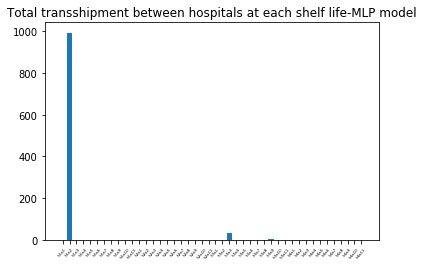

In [145]:
plt.close('all')
plt.bar(np.arange(44), np.sum(TSsmatrix,axis=0))
plt.xticks(np.arange(44),['h1a1','h1a2','h1a3','h1a4','h1a5','h1a6','h1a7','h1a8','h1a9','h1a10','h1a11',
                'h2a1','h2a2','h2a3','h2a4','h2a5','h2a6','h2a7','h2a8','h2a9','h2a10','h2a11',
                'h3a1','h3a2','h3a3','h3a4','h3a5','h3a6','h3a7','h3a8','h3a9','h3a10','h3a11',
                'h4a1','h4a2','h4a3','h4a4','h4a5','h4a6','h4a7','h4a8','h4a9','h4a10','h4a11'] 
          ,fontsize=4,rotation=49)
plt.title('Total transshipment between hospitals at each shelf life-MLP model')
plt.savefig('RIDntransshipmentAge.pdf',bbox_inches='tight')

In [146]:
Inve_TS=xin[:,0:44]-TSsmatrix[:,0:44]

In [147]:
print(Inve_TS.shape)

Inve_TS

Negatives=np.where(Inve_TS<0)

NegativeAge=Negatives[1]

NegativeDay=Negatives[0]

len(Inve_TS[NegativeDay,NegativeAge])

(9250, 44)


8

In [148]:
len(Inve_TS[NegativeDay,NegativeAge])/1850

0.004324324324324324

In [149]:
TSsmatrix=np.array(TSsumAge)
#TSsmatrix=TSsumAge.as_matrix(columns=None)

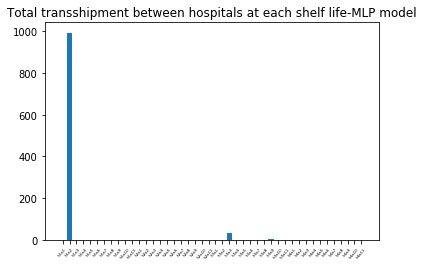

In [150]:
plt.close('all')
plt.bar(np.arange(44), np.sum(TSsmatrix,axis=0))
plt.xticks(np.arange(44),['h1a1','h1a2','h1a3','h1a4','h1a5','h1a6','h1a7','h1a8','h1a9','h1a10','h1a11',
                'h2a1','h2a2','h2a3','h2a4','h2a5','h2a6','h2a7','h2a8','h2a9','h2a10','h2a11',
                'h3a1','h3a2','h3a3','h3a4','h3a5','h3a6','h3a7','h3a8','h3a9','h3a10','h3a11',
                'h4a1','h4a2','h4a3','h4a4','h4a5','h4a6','h4a7','h4a8','h4a9','h4a10','h4a11'] 
          ,fontsize=4,rotation=49)
plt.title('Total transshipment between hospitals at each shelf life-MLP model')
plt.savefig('RIDntransshipmentAge.pdf',bbox_inches='tight')

In [151]:
Inve_TS=xin[:,0:44]-TSsmatrix[:,0:44]

In [152]:
print(Inve_TS.shape)

Inve_TS

Negatives=np.where(Inve_TS<0)

NegativeAge=Negatives[1]

NegativeDay=Negatives[0]

len(Inve_TS[NegativeDay,NegativeAge])

(9250, 44)


8

In [580]:
len(Inve_TS[NegativeDay,NegativeAge])/1850

0.0075675675675675675

In [134]:
f = open('inventoryNewDemand.txt', 'r')
split=[line.strip('[[') for line in f]
#[print(line[0:2]) for line in f]

f.close()

In [135]:
xin=np.empty((0,44))
for i in np.arange(len(split)):
    
    if len(split[i])==1:
        continue
        
        
    xi=inventoryread(split,i)
    xin=np.append(xin,xi,axis=0)
         

In [136]:
len(split)

9251

In [137]:
xin.shape

(9250, 44)

In [138]:
SDinputs=np.std(xin,axis=0)

In [139]:
MEANinputs=np.mean(xin,axis=0)

In [140]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'mean')

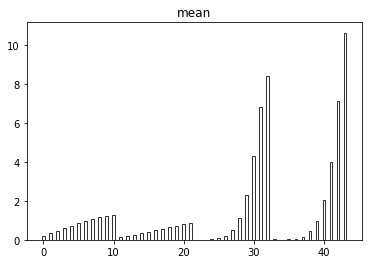

In [141]:
plt.bar(np.arange(44),MEANinputs,align='center',width=0.4, alpha=0.8, facecolor='None', edgecolor='black')
plt.title('mean')

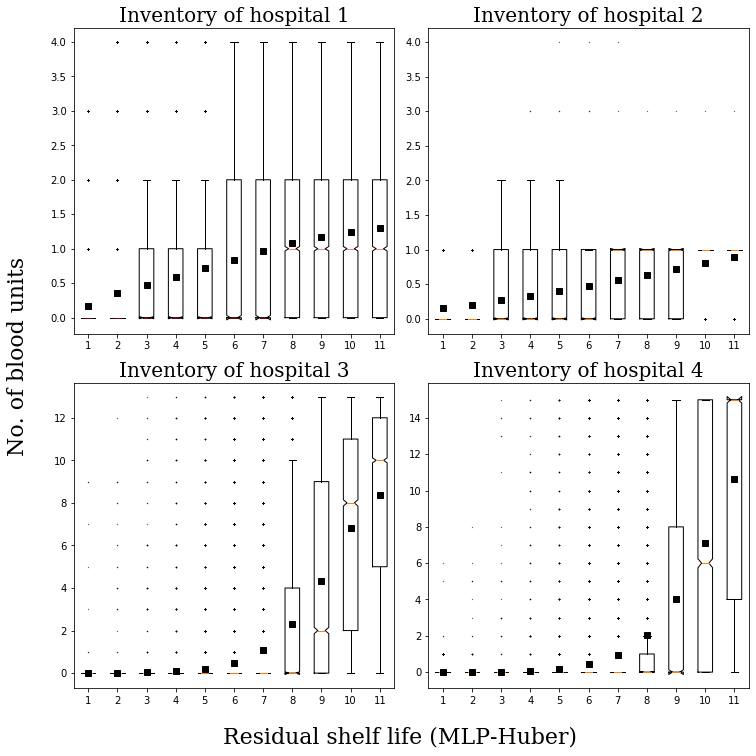

In [142]:
X=xin
fig, axes = plt.subplots(2, 2, sharex=False,sharey=False,figsize=(10,10),  tight_layout=True)
distance = []
n_bins1 = 15
n_bins2 = 20

outlayersprops = dict(markerfacecolor='k',markersize=0.5, marker='.')
medianprops = dict(linestyle='-', linewidth=0.5, color='red')
meanprops = dict(marker='s',markerfacecolor='k',markeredgecolor='k')

# H1
#axes[1].subplot(221,sharex='col')
axes[0,0].boxplot(X[:,0:11],notch=True,showmeans=True, meanprops=meanprops,medianprops=medianprops,flierprops=outlayersprops)
#axes[0,0].errorbar(np.arange(11)+1,MEANinputs[0:11], yerr=SDinputs[0:11], fmt='None', alpha=0.7, elinewidth=0.7,ecolor='black', capsize=5)

axes[0,0].set_title('Inventory of hospital 1',fontname='serif',fontsize=20)
axes[0,0].grid(False)


# H2
axes[0,1].boxplot(X[:,11:22],notch=True,showmeans=True, meanprops=meanprops,flierprops=outlayersprops)
#axes[0,1].errorbar(np.arange(11)+1,MEANinputs[11:22], yerr=SDinputs[11:22], fmt='None', alpha=0.7, elinewidth=0.7,ecolor='black', capsize=5)

axes[0,1].set_title('Inventory of hospital 2',fontname='serif',fontsize=20)
axes[0,1].grid(False)


# H3
axes[1,0].boxplot(X[:,22:33],notch=True,showmeans=True, meanprops=meanprops,flierprops=outlayersprops)
#axes[1,0].errorbar(np.arange(11)+1,MEANinputs[22:33], yerr=SDinputs[22:33], fmt='None', alpha=0.7, elinewidth=0.7,ecolor='black', capsize=5)

axes[1,0].set_title('Inventory of hospital 3',fontname='serif',fontsize=20)
axes[1,0].grid(False)

# H4
axes[1,1].boxplot(X[:,33:44],notch=True,showmeans=True, meanprops=meanprops,flierprops=outlayersprops)
#axes[1,1].errorbar(np.arange(11)+1,MEANinputs[33:44], SDinputs[33:44], fmt='None', alpha=0.7, elinewidth=0.7,ecolor='black', capsize=5)

axes[1,1].set_title('linear')
axes[1,1].set_title('Inventory of hospital 4',fontname='serif',fontsize=20)
axes[1,1].grid(False)
# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
#plt.gca().yaxis.set_minor_formatter(NullFormatter())
# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
plt.subplots_adjust(top=1, bottom=0.05, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.35)
fig.text(-0.03, 0.5, 'No. of blood units', ha='center', va='center',rotation='vertical',fontname='serif',fontsize=22)
fig.text(0.5, -0.03, 'Residual shelf life (MLP-Huber)', ha='center', va='center',fontname='serif',fontsize=22)

plt.savefig('MLP_HuberInventory.pdf',format='pdf', dpi=200,bbox_inches='tight')
plt.show()